## 导入库

In [1]:
import keras
#from PIL import Image
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
#from PIL import Image
from keras.utils import to_categorical
import random

## 数据预处理

In [2]:
train_per = 0.6
val_per = 0.2
test_per = 1 - train_per - val_per
print("train_per:", train_per)
print("val_per:", val_per)
print("test_per:", test_per)

train_per: 0.6
val_per: 0.2
test_per: 0.2


In [3]:
image1 = [None] * 1573
label1 = [None] * 1573
image2 = [None] * 1573
label2 = [None] * 1573
#创建数据集列表
data_amount = 0

n = 0

#insulting
for i in range(1,1571):
    #
    data_place_one = './data_training_20240217/insulting/' + str(i) + '.jpg'
    #print(data_place_one)
    img_2 = cv2.imread(data_place_one)
    if img_2 is not None:
        n += 1
        data_amount += 1
        image1[i-1] = np.array(img_2)
        label1[i-1] = 1
    else:
        pass
        #print("Failed to load image. or not exist")

#uninsulting
for i in range(1,1571):
    data_place_one = './data_training_20240217/uninsulting/' + str(i) + '.jpg'
    #print(data_place_one)
    img_2 = cv2.imread(data_place_one)
    if img_2 is not None:
        n += 1
        data_amount += 1
        image2[i-1] = np.array(img_2)
        label2[i-1] = 0
    else:
        pass
        #print("Failed to load image. or not exist")
#print(img)

label = label1+label2
image = image1+image2

#删除空值
label = [x for x in label if x != None]
image = [x for x in image if np.any(x)]


combined_list = list(zip(label, image))
# 打乱元组列表
random.shuffle(combined_list)
# 恢复两个列表
label, image = zip(*combined_list)

train_num = round(len(image) * train_per)
val_num = round(len(image) * val_per)
test_num = round(len(image) * test_per)
print("train_num:",train_num)
print("val_num:",val_num)
print("test_num:",test_num)

val_image = image[train_num : train_num + val_num]
val_label = label[train_num : train_num + val_num]
test_image = image[train_num + val_num :]
test_label = label[train_num + val_num :]
train_image = image[: train_num]
train_label = label[: train_num]

train_num: 1884
val_num: 628
test_num: 628


In [4]:
train_label = np.array(train_label)
train_image = np.array(train_image)
val_label = np.array(val_label)
val_image = np.array(val_image)
test_label = np.array(test_label)
test_image = np.array(test_image)
#print(train_label.shape)
# 将标签数据进行one-hot编码
train_label_encoded = to_categorical(train_label, num_classes=2)
test_label_encoded = to_categorical(test_label, num_classes=2)
val_label_encoded = to_categorical(val_label, num_classes=2)

## 模型构建

In [24]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

#### 残差投影

In [25]:
def C1(x):
    x = layers.Conv2D(filters=8, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    return x

In [26]:
def residual_block(x, filters_size1, filters_size2, filters_size3, stride = 1):
    residual = x
    x = layers.Conv2D(filters = filters_size1, kernel_size=1, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters = filters_size2, kernel_size=3, activation="relu", strides = stride, padding="same")(x)
    x = layers.Conv2D(filters = filters_size3, kernel_size=1, activation="relu", padding="same")(x)

    residual = layers.Conv2D(filters = filters_size3, kernel_size=1, activation="relu", strides = stride, padding="same")(residual)

    x = layers.add([x,residual])
    return x



In [43]:
inputs_emoji = keras.Input(shape=(128,128,3))
#x = data_augmentation(inputs_emoji)
#x = layers.Rescaling(1./255)(x)
x = C1(inputs_emoji)
C2 = residual_block(x, 8,8,32,stride = 2)
C3 = residual_block(C2, 16,16,64,stride = 2)
C4 = residual_block(C3, 32,32,128,stride = 2)
C4 = residual_block(C4, 32,32,128,stride = 1)

G4 = C4
G4 = layers.Conv2D(filters = 16, kernel_size=1, activation="relu", strides = 1, padding="same", name = "G4")(G4)
P4 = layers.Flatten()(G4)
P4 = layers.Dense(2, activation="sigmoid", name = "P4")(P4)

C3 = layers.Conv2D(filters = 16, kernel_size=1, activation="relu", strides = 2, padding="same", name = "C3")(C3)
G3 = layers.add([G4,C3], name = "G3")
P3 = layers.Flatten()(G3)
P3 = layers.Dense(2, activation="sigmoid", name = "P3")(P3)

C2 = layers.Conv2D(filters = 16, kernel_size=1, activation="relu", strides = 4, padding="same", name = "C2")(C2)
G2 = layers.add([G3,C2], name = "G2")
P2 = layers.Flatten()(G2)
P2 = layers.Dense(2, activation="sigmoid", name = "P2")(P2)

G_all = layers.add([G2,G3,G4], name = "G_all")
P_all = layers.Flatten()(G_all)
P_all = layers.Dense(2, activation="sigmoid", name = "P_all")(P_all)

outputs_result = layers.Dense(2,activation="sigmoid")(x)
model = keras.Model(inputs = inputs_emoji,outputs = [P4,P3,P2,P_all])

In [44]:
model.summary()
keras.utils.plot_model(model,show_shapes=True)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_60 (Conv2D)          (None, 128, 128, 8)          224       ['input_5[0][0]']             
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 8)            0         ['conv2d_60[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_61 (Conv2D)          (None, 64, 64, 8)            72        ['max_pooling2d_4[0][0]'

In [45]:
callbacks_list = [
    
    keras.callbacks.ModelCheckpoint(
        filepath='./model/model_HGCN_20240405t1905.h5',
        monitor="val_loss",
        save_best_only=True
    )
]

In [46]:
model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

## 模型训练

In [47]:
epochs_ = 40
history = model.fit(train_image,
        [train_label_encoded,train_label_encoded,train_label_encoded,train_label_encoded],
        epochs=epochs_,
        batch_size=100,
        #callbacks=callbacks_list,
        validation_data=(val_image,[val_label_encoded,val_label_encoded,val_label_encoded,val_label_encoded])
        )

Epoch 1/40
19/19 [==============================] - 7s 250ms/step - loss: 67.3212 - P4_loss: 2.6536 - P3_loss: 10.8659 - P2_loss: 20.2925 - P_all_loss: 33.5092 - P4_accuracy: 0.5143 - P3_accuracy: 0.5260 - P2_accuracy: 0.5234 - P_all_accuracy: 0.5366 - val_loss: 16.8812 - val_P4_loss: 0.7090 - val_P3_loss: 2.2103 - val_P2_loss: 6.2242 - val_P_all_loss: 7.7377 - val_P4_accuracy: 0.5127 - val_P3_accuracy: 0.5382 - val_P2_accuracy: 0.5366 - val_P_all_accuracy: 0.5430
Epoch 2/40
19/19 [==============================] - 4s 230ms/step - loss: 15.5542 - P4_loss: 0.7066 - P3_loss: 1.7585 - P2_loss: 6.1824 - P_all_loss: 6.9066 - P4_accuracy: 0.5106 - P3_accuracy: 0.5791 - P2_accuracy: 0.5441 - P_all_accuracy: 0.5653 - val_loss: 11.1333 - val_P4_loss: 0.6940 - val_P3_loss: 1.1815 - val_P2_loss: 4.1512 - val_P_all_loss: 5.1066 - val_P4_accuracy: 0.5016 - val_P3_accuracy: 0.5637 - val_P2_accuracy: 0.5876 - val_P_all_accuracy: 0.5732
Epoch 3/40
19/19 [==============================] - 4s 229ms/step

In [48]:
model.save('./model/model_HGCN_20240405t1905.h5')

C:\Users\Victor\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 模型评估

In [49]:
history_dir = history.history
print(history_dir.keys())

dict_keys(['loss', 'P4_loss', 'P3_loss', 'P2_loss', 'P_all_loss', 'P4_accuracy', 'P3_accuracy', 'P2_accuracy', 'P_all_accuracy', 'val_loss', 'val_P4_loss', 'val_P3_loss', 'val_P2_loss', 'val_P_all_loss', 'val_P4_accuracy', 'val_P3_accuracy', 'val_P2_accuracy', 'val_P_all_accuracy'])


dict_keys(['loss', 'P4_loss', 'P3_loss', 'P2_loss', 'P_all_loss', 'P4_accuracy', 'P3_accuracy', 'P2_accuracy', 'P_all_accuracy', 'val_loss', 'val_P4_loss', 'val_P3_loss', 'val_P2_loss', 'val_P_all_loss', 'val_P4_accuracy', 'val_P3_accuracy', 'val_P2_accuracy', 'val_P_all_accuracy'])


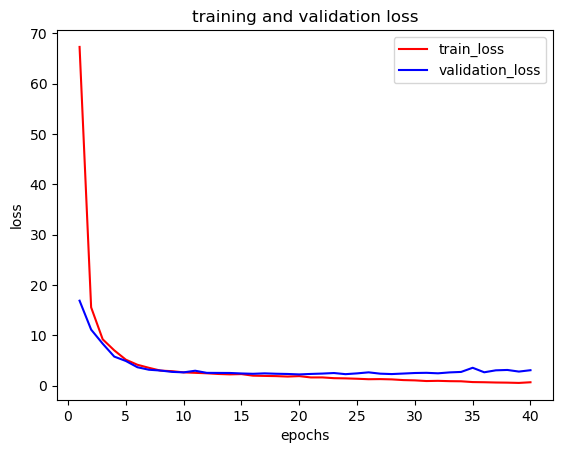

In [50]:
history_dir = history.history
print(history_dir.keys())
loss_values = history_dir["loss"]
P4_accuracy_values = history_dir["P4_accuracy"]
P3_accuracy_values = history_dir["P3_accuracy"]
P2_accuracy_values = history_dir["P2_accuracy"]
P_all_accuracy_values = history_dir["P_all_accuracy"]

val_loss_values = history_dir["val_loss"]
val_P4_accuracy_values = history_dir["val_P4_accuracy"]
val_P3_accuracy_values = history_dir["val_P3_accuracy"]
val_P2_accuracy_values = history_dir["val_P2_accuracy"]
val_P_all_accuracy_values = history_dir["val_P_all_accuracy"]

x_epochs = range(1,epochs_+1)
plt.plot(x_epochs,loss_values,"r",label = "train_loss")
plt.plot(x_epochs,val_loss_values,"b",label = "validation_loss")
plt.title("training and validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

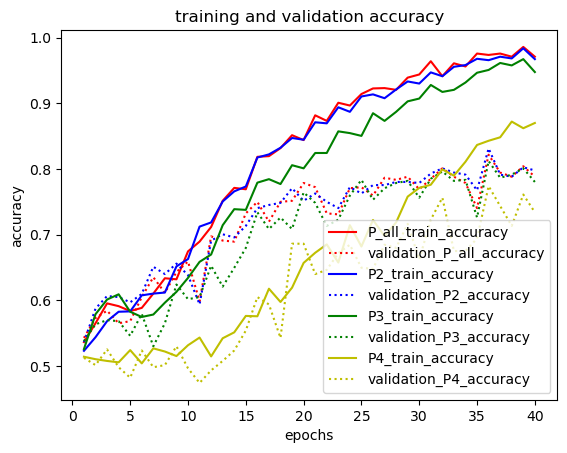

In [51]:
plt.plot(x_epochs,P_all_accuracy_values,"r",label = "P_all_train_accuracy")
plt.plot(x_epochs,val_P_all_accuracy_values,"r:",label = "validation_P_all_accuracy")
plt.plot(x_epochs,P2_accuracy_values,"b",label = "P2_train_accuracy")
plt.plot(x_epochs,val_P2_accuracy_values,"b:",label = "validation_P2_accuracy")
plt.plot(x_epochs,P3_accuracy_values,"g",label = "P3_train_accuracy")
plt.plot(x_epochs,val_P3_accuracy_values,"g:",label = "validation_P3_accuracy")
plt.plot(x_epochs,P4_accuracy_values,"y",label = "P4_train_accuracy")
plt.plot(x_epochs,val_P4_accuracy_values,"y:",label = "validation_P4_accuracy")
plt.title("training and validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [52]:
results = model.evaluate(test_image,test_label_encoded)
print("test_loss:",results[0],"; test_accuracy:",results[1])
print("P4_test_accuracy:",results[5])
print("P3_test_accuracy:",results[6])
print("P2_test_accuracy:",results[7])
print("P_all_test_accuracy:",results[8])

20/20 [==============================] - 1s 24ms/step - loss: 3.1840 - P4_loss: 0.6482 - P3_loss: 0.6976 - P2_loss: 0.8144 - P_all_loss: 1.0238 - P4_accuracy: 0.7373 - P3_accuracy: 0.7596 - P2_accuracy: 0.7898 - P_all_accuracy: 0.7850
test_loss: 3.184042453765869 ; test_accuracy: 0.6482417583465576
P4_test_accuracy: 0.737261176109314
P3_test_accuracy: 0.7595541477203369
P2_test_accuracy: 0.7898089289665222
P_all_test_accuracy: 0.7850318551063538
